In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
c = np.array([[1,0,0,0,0,0,0]])
W = np.random.rand(7,3)
h = np.matmul(c, W)
print(h)

[[0.03179391 0.16443182 0.94743994]]


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2')  
import numpy as np
from common.layers import MatMul

c = np.array([1,0,0,0,0,0,0])
W = np.random.rand(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[0.48197546 0.54636552 0.10734481]


In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2')  
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

# 가중치 초기화
W_in = np.random.rand(7, 3)
W_out = np.random.rand(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[0.79605019 0.99413792 0.57645879 0.86804874 0.98197789 1.3245487
 1.19560008]


In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2')  
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [ ]:
corpus[1:-1]

array([1, 2, 3, 4, 1, 5])

## CBOW

Q. Softmaxwithloss 함수 구성

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [ ]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size + 1):
      if t == 0:
        continue
        cs.append(corpus[idx + t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2')  
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1) 

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2')  
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size
    
    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    # 계층 생성
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    # 모든 가중치와 기울기를 리스트에 모음.
    layers = [self.in_layer0, self.in_layer1, self.out_layer] 
    self.params, self.grads = [], []  
    for layer in layers: 
      self.params += layer.params  
      self.grads += layer.grads  
    
    # 인스턴스 변수에 단어의 분산 표현을 저장함.
    self.word_vecs = W_in

  def forward(self, contexts, target): # contexts: [0, 2], target: 1이라고 가정.
    h0 = self.in_layer0.forward(contexts[:, 0]) # contexts에서 1번째(0) 원소 one hot vector로 변환 * W_in
    h1 = self.in_layer0.forward(contexts[:, 1]) # contexts에서 2번째(2) 원소 one hot vector로 변환 * W_in
    h = (h0 + h1) * 0.5    # h0와 h1 평균
    score = self.out_layer.forward(h)    # h * W_out
    loss = self.loss_layer.forward(score, target)  # score를 softmax한 뒤 1을 one hot vector 변환한 것과의 차이 계산   
    return loss

  def backward(self, dout=1): # MatMul과 SoftmaxWithLoss에 정의된 backward 가져다 쓰기. 그림 [3-20] 참고
    ds = self.loss_layer.backward(dout) # ds: SoftmaxwithLoss 계층의 역전파 출력.
    da = self.out_layer.backward(ds)    # da: W_out 역전파 출력
    da *= 0.5    # 앞서 h에서 0.5를 곱했으니 역전파에서도 0.5 곱함.
    self.in_layer1.backward(da)    # 기울기 가중치(dW) 갱신해 grads에 저장, 출력 더 이상 안 받아도 됨.
    self.in_layer0.backward(da)    # 기울기 가중치(dW) 갱신해 grads에 저장, 출력 더 이상 안 받아도 됨.
    return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

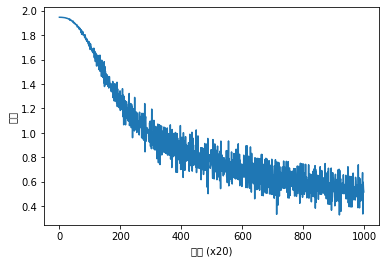

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2')  
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1 ; hidden_size = 5;
batch_size = 3 ; max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.5311487 -1.0376858  1.085137   0.9544282 -0.9563247]
say [-1.3741709  0.5586383 -1.1311767 -1.1641409  1.1283599]
goodbye [-0.19549383 -0.8040657   0.8778384   0.9395232  -1.0073199 ]
and [-1.3063909   1.8548789  -0.67981803 -0.59032047  0.7107239 ]
i [-0.17845874 -0.79844785  0.88750833  0.9709369  -1.0179437 ]
hello [-1.5441331  -1.0530485   1.0732889   0.94358724 -0.9658449 ]
. [-1.0515598 -1.8549302 -1.2110521 -1.2798523  1.2175107]


## Skip-gram

In [ ]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size + 1):
      if t == 0:
        continue
        cs.append(corpus[idx + t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [ ]:
from common.util import create_contexts_target

target, contexts = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[1 2 3 4 1 5]
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [ ]:
print(target[:, 0])

[0 1 2 3 4 1]


In [ ]:
# SimpleSkipGram 구현
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/밑바닥부터시작하는딥러닝2') 
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)        # W_out이 하나만 존재하는 이유?
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):    # input이 index 1, 주변 단어 index 0과 2라 가정.
        h = self.in_layer.forward(target)   # 1을 one hot vector로 변환하고 * W_in
        s = self.out_layer.forward(h)       # W_out이랑 곱하고
        l1 = self.loss_layer1.forward(s, contexts[:, 0])    # s를 softmax 취하고 0의 one hot vector와 비교해 loss 계산
        l2 = self.loss_layer2.forward(s, contexts[:, 1])    # s를 softmax 취하고 2의 one hot vector와 비교해 loss 계산
        loss = l1 + l2 # 두 개의 loss 더하기.
        return loss

    def backward(self, dout=1):    # 그림 [3-20] 처럼 그리기 가능??
        dl1 = self.loss_layer1.backward(dout)   # dl1: 첫 번째 SoftmaxwithLoss 계층의 역전파 출력.
        dl2 = self.loss_layer2.backward(dout)   # dl2: 두 번째 SoftmaxwithLoss 계층의 역전파 출력.
        ds = dl1 + dl2                          # ds: 두 개의 역전파 출력을 더해준 값
        dh = self.out_layer.backward(ds)        # dh: W_out 역전파 출력
        self.in_layer.backward(dh)              # 기울기 가중치 갱신, 출력 저장할 필요 없음. 
        return None